# Weather(TEMP and HUMIDITY) VS LFB AND LAS CALLS

#### NASA/POWER CERES/MERRA2 Native Resolution Hourly Data 
- Dates (month/day/year): 01/01/2020 through 06/01/2023 
- Location: Latitude  51.5072   Longitude -0.1276 
- Elevation from MERRA-2: Average for 0.5 x 0.625 degree lat/lon region = 73.15 meters
- The value for missing source data that cannot be computed or is outside of the sources availability range: -999 
- Parameter(s): 
    - T2M             MERRA-2 Temperature at 2 Meters (C) 
    - QV2M            MERRA-2 Specific Humidity at 2 Meters (g/kg) 
    - PRECTOTCORR     MERRA-2 Precipitation Corrected (mm/hour) 
    - PS              MERRA-2 Surface Pressure (kPa)
    - WS10M           MERRA-2 Wind Speed at 10 Meters (m/s) 

#### NASA/POWER CERES/MERRA2 Native Resolution Daily Data 
- Dates (month/day/year): 01/01/2021 through 03/31/2021 
- Location: Latitude  51.5072   Longitude -0.1276 
- Elevation from MERRA-2: Average for 0.5 x 0.625 degree lat/lon region = 73.15 meters
- The value for missing source data that cannot be computed or is outside of the sources availability range: -999 
- Parameter(s): 
    - T2M             MERRA-2 Temperature at 2 Meters (C) 
    - QV2M            MERRA-2 Specific Humidity at 2 Meters (g/kg) 
    - PS              MERRA-2 Surface Pressure (kPa) 
    - WS10M           MERRA-2 Wind Speed at 10 Meters (m/s) 
    - PRECTOTCORR     MERRA-2 Precipitation Corrected (mm/day) 

In [1]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

pd.options.display.max_columns = 999
sns.set_theme()

/Users/mahsumkocabey/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# colour blind codes
colors = {
    'blue':    '#377eb8', 
    'orange':  '#ff7f00',
    'green':   '#4daf4a',
    'pink':    '#f781bf',
    'brown':   '#a65628',
    'purple':  '#984ea3',
    'gray':    '#999999',
    'red':     '#e41a1c',
    'yellow':  '#dede00'
} 

### Import the data sets

In [3]:
# Weather Data Sets
daily = pd.read_csv("../data/Weather/daily_weather_data.csv")
hourly = pd.read_csv("../data/Weather/hourly_weather_data.csv")
daily_max_temp = pd.read_csv("../data/Weather/daily_max_temp.csv")

# LFB Data Set
lfb_d = pd.read_csv('../data/LFB/LFB Incident data 2020 to 2023.csv')

# LAS Data Sets
file_path = '../data/LAS/DataApril2023/LAS-From 2018 to 2023.xlsx'
H_Calls = pd.read_excel(file_path, engine='openpyxl', sheet_name='HourlyCalls')
I_LSOA = pd.read_excel(file_path, engine='openpyxl', sheet_name='IncidentsLSOA')

**Cache the DATA**

In [4]:
daily_weather = daily.copy()
hourly_weather = hourly.copy()
daily_max_temp_weather = daily_max_temp.copy()
lfb_data = lfb_d.copy()
HourlyCalls = H_Calls.copy()
IncidentsLSOA = I_LSOA.copy()

### Data Manipulation

In [5]:
daily_weather['DATE'] = pd.to_datetime(daily_weather[['YEAR', 'MONTH', 'DAY']])
hourly_weather['DATE'] = pd.to_datetime(hourly_weather[['YEAR', 'MONTH', 'DAY']])
daily_max_temp_weather['DATE'] = pd.to_datetime(daily_max_temp_weather[['YEAR', 'MONTH', 'DAY']])

# LFB Data Manipulation
# Convert "DateOfCall" to datetime format
lfb_data['DateOfCall'] = pd.to_datetime(lfb_data['DateOfCall'], format='%d %b %Y')
# Create a new column "CalMonth" with the month names
lfb_data['CalMonth'] = lfb_data['DateOfCall'].dt.month_name()

# LAS Data Manipulation
# Ensure that the 'date' column is a datetime object
HourlyCalls['date'] = pd.to_datetime(HourlyCalls['date'])

# Specify start and end dates
start_date = '2021-01-01'
end_date = '2023-01-31'

# Assuming 'year' is numeric and 'month' is string with full month name (e.g. 'January')
IncidentsLSOA['date'] = pd.to_datetime(IncidentsLSOA['year'].astype(str) + ' ' + IncidentsLSOA['month'], format="%Y %B")


# Create a mask of boolean values indicating whether each date is within the specified range
mask = (HourlyCalls['date'] >= start_date) & (HourlyCalls['date'] <= end_date)
# Create a mask of boolean values indicating whether each date is within the specified range
mask_two = (IncidentsLSOA['date'] >= start_date) & (IncidentsLSOA['date'] <= end_date)

# Apply the mask to the DataFrame to get a new DataFrame with dates within the specified range
HourlyCalls = HourlyCalls.loc[mask].reset_index(drop=True)

# Apply the mask to the DataFrame to get a new DataFrame with dates within the specified range
IncidentsLSOA = IncidentsLSOA.loc[mask_two].reset_index(drop=True)

### Merge the data frames

In [6]:
las_data = HourlyCalls.groupby(['date'])['calls999'].sum().reset_index().rename(columns={'calls999': 'LAS'})
lfb_data = lfb_data.groupby(['DateOfCall'])['NumCalls'].sum().reset_index().rename(columns={'NumCalls': 'LFB'})

In [7]:
merged = daily_max_temp_weather.merge(lfb_data, how='inner', left_on='DATE', right_on='DateOfCall').drop(columns=['DateOfCall'])
merged = merged.merge(las_data, how='inner', left_on='DATE', right_on='date').drop(columns=['date'])

### Normalise the DATA

In [8]:
# Initialize a scaler
scaler = MinMaxScaler()

merged_22_23 = merged.loc[merged['YEAR'] >= 2021].copy()

# Sort the dataframe by 'DATE' before plotting
merged_22_23 = merged_22_23.sort_values(by='DATE')



# Add Week Number
merged_22_23['WEEK'] = merged_22_23['DATE'].dt.isocalendar().week

# Group them by WEEK-Month
daily =  merged_22_23.copy()
avg_daily =  merged_22_23.groupby(['MONTH', 'DAY'])[['TEMP','HUMIDITY','PRECIPITATION','WIND_SPEED','MAX_TEMP','LFB','LAS']].mean().reset_index()
weekly = merged_22_23.groupby(['WEEK']).mean().reset_index()
monthly = merged_22_23.groupby(['MONTH']).mean().reset_index()


# Apply the scaler to 'NumCalls' and 'TotalIncidents'
daily[['NORM_MAX_TEMP', 'NORM_HUMIDITY', 'NORM_LFB', 'NORM_LAS']] = scaler.fit_transform(daily[['MAX_TEMP', 'HUMIDITY', 'LFB', 'LAS']])
avg_daily[['NORM_MAX_TEMP', 'NORM_HUMIDITY', 'NORM_LFB', 'NORM_LAS']] = scaler.fit_transform(avg_daily[['MAX_TEMP', 'HUMIDITY', 'LFB', 'LAS']])
weekly[['NORM_MAX_TEMP', 'NORM_HUMIDITY', 'NORM_LFB', 'NORM_LAS']] = scaler.fit_transform(weekly[['MAX_TEMP', 'HUMIDITY', 'LFB', 'LAS']])
monthly[['NORM_MAX_TEMP', 'NORM_HUMIDITY', 'NORM_LFB', 'NORM_LAS']] = scaler.fit_transform(monthly[['MAX_TEMP', 'HUMIDITY', 'LFB', 'LAS']])

In [9]:
avg_daily

,MONTH,DAY,TEMP,HUMIDITY,PRECIPITATION,WIND_SPEED,MAX_TEMP,LFB,LAS,NORM_MAX_TEMP,NORM_HUMIDITY,NORM_LFB,NORM_LAS
0,1,1,6.890000,6.143333,5.496667,0.973333,8.663333,492.333333,6076.666667,0.176635,0.352512,0.263113,0.879548
1,1,2,5.330000,5.453333,5.076667,1.396667,7.410000,310.000000,5171.000000,0.131791,0.266208,0.028902,0.518725
2,1,3,5.973333,5.736667,6.380000,2.593333,8.473333,315.000000,5111.000000,0.169837,0.301647,0.035324,0.494821
3,1,4,5.670000,5.553333,7.440000,1.696667,8.043333,298.333333,5476.666667,0.154452,0.278716,0.013916,0.640505
4,1,5,4.136667,5.003333,6.480000,1.096667,7.063333,336.000000,5333.333333,0.119387,0.209923,0.062299,0.583400
...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,12,27,7.440000,6.320000,6.035000,4.175000,9.665000,356.000000,4796.000000,0.212475,0.374609,0.087990,0.369323
361,12,28,9.185000,6.925000,9.085000,5.565000,10.340000,332.500000,4991.000000,0.236627,0.450281,0.057803,0.447012
362,12,29,8.255000,6.565000,7.435000,1.650000,10.960000,343.500000,5308.000000,0.258811,0.405253,0.071933,0.573307
363,12,30,10.580000,7.660000,8.990000,2.940000,12.860000,371.500000,5303.000000,0.326793,0.542214,0.107900,0.571315


## Visualisations and Correlation Coefficient for the last 2 years

#### Daily Correlation

In [10]:
# Select the columns you are interested in
daily_selected = avg_daily[['LFB', 'LAS', 'MAX_TEMP', 'HUMIDITY']]

# Calculate the correlation matrix
daily_corr = daily_selected.corr()

# Print the correlation matrix
print("DAILY:")
print(daily_corr)

DAILY:
               LFB       LAS  MAX_TEMP  HUMIDITY
LFB       1.000000  0.451904  0.549521  0.518304
LAS       0.451904  1.000000  0.407347  0.525913
MAX_TEMP  0.549521  0.407347  1.000000  0.921232
HUMIDITY  0.518304  0.525913  0.921232  1.000000


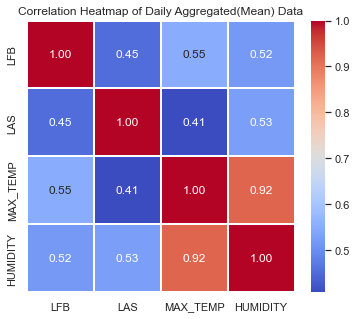

In [11]:
# Create a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(daily_corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.05)

# Add title
plt.title('Correlation Heatmap of Daily Aggregated(Mean) Data')
# Display the heatmap
plt.show()

**Weekly Correlation**

In [12]:
# Select the columns you are interested in
weekly_selected = weekly[['LFB', 'LAS', 'MAX_TEMP', 'HUMIDITY']]

# Calculate the correlation matrix
weekly_corr = weekly_selected.corr()

# Print the correlation matrix
print("WEEKLY:")
print(weekly_corr)

WEEKLY:
               LFB       LAS  MAX_TEMP  HUMIDITY
LFB       1.000000  0.439386  0.680184  0.662571
LAS       0.439386  1.000000  0.292620  0.428724
MAX_TEMP  0.680184  0.292620  1.000000  0.946548
HUMIDITY  0.662571  0.428724  0.946548  1.000000


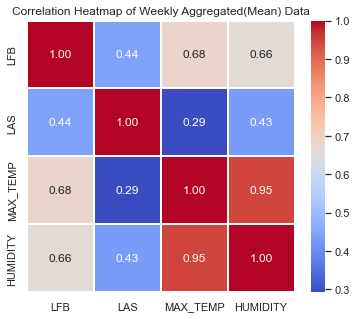

In [13]:
# Create a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(weekly_corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.05)

# Add title
plt.title('Correlation Heatmap of Weekly Aggregated(Mean) Data')
# Display the heatmap
plt.show()

**Monthly Correlation**

In [14]:
# Select the columns you are interested in
monthly_selected = monthly[['LFB', 'LAS', 'MAX_TEMP', 'HUMIDITY']]

# Calculate the correlation matrix
monthly_corr = monthly_selected.corr()

# Print the correlation matrix
print("Monthly")
print(monthly_corr)

Monthly
               LFB       LAS  MAX_TEMP  HUMIDITY
LFB       1.000000  0.651102  0.787248  0.803004
LAS       0.651102  1.000000  0.485998  0.652163
MAX_TEMP  0.787248  0.485998  1.000000  0.957060
HUMIDITY  0.803004  0.652163  0.957060  1.000000


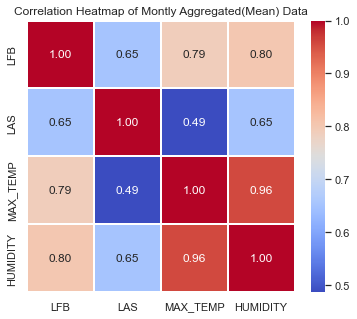

In [15]:
# Create a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(monthly_corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.05)

# Add title
plt.title('Correlation Heatmap of Montly Aggregated(Mean) Data')
# Display the heatmap
plt.show()

#### Visuals

### DAILY

In [16]:
daily

,YEAR,MONTH,DAY,TEMP,HUMIDITY,PRECIPITATION,WIND_SPEED,MAX_TEMP,DATE,LFB,LAS,WEEK,NORM_MAX_TEMP,NORM_HUMIDITY,NORM_LFB,NORM_LAS
0,2021,1,1,0.69,3.91,2.86,1.49,2.84,2021-01-01,415.0,6498,53,0.103790,0.173077,0.149289,0.839342
1,2021,1,2,1.18,3.97,3.77,0.24,3.50,2021-01-02,298.0,6285,53,0.122455,0.179150,0.056872,0.787805
2,2021,1,3,1.93,4.15,4.68,0.69,4.40,2021-01-03,262.0,5979,53,0.147907,0.197368,0.028436,0.713767
3,2021,1,4,2.32,4.27,7.14,1.99,4.58,2021-01-04,267.0,7162,1,0.152998,0.209514,0.032385,1.000000
4,2021,1,5,1.69,4.09,6.66,2.47,3.90,2021-01-05,253.0,6885,1,0.133767,0.191296,0.021327,0.932978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756,2023,1,27,2.44,4.15,4.71,0.30,6.28,2023-01-27,422.0,4169,4,0.201075,0.197368,0.154818,0.275829
757,2023,1,28,1.45,3.91,2.41,0.24,5.40,2023-01-28,370.0,3862,4,0.176188,0.173077,0.113744,0.201549
758,2023,1,29,3.62,4.82,4.92,0.51,6.60,2023-01-29,414.0,3730,4,0.210124,0.265182,0.148499,0.169610
759,2023,1,30,4.26,4.82,5.36,0.20,7.64,2023-01-30,387.0,4059,5,0.239536,0.265182,0.127172,0.249214


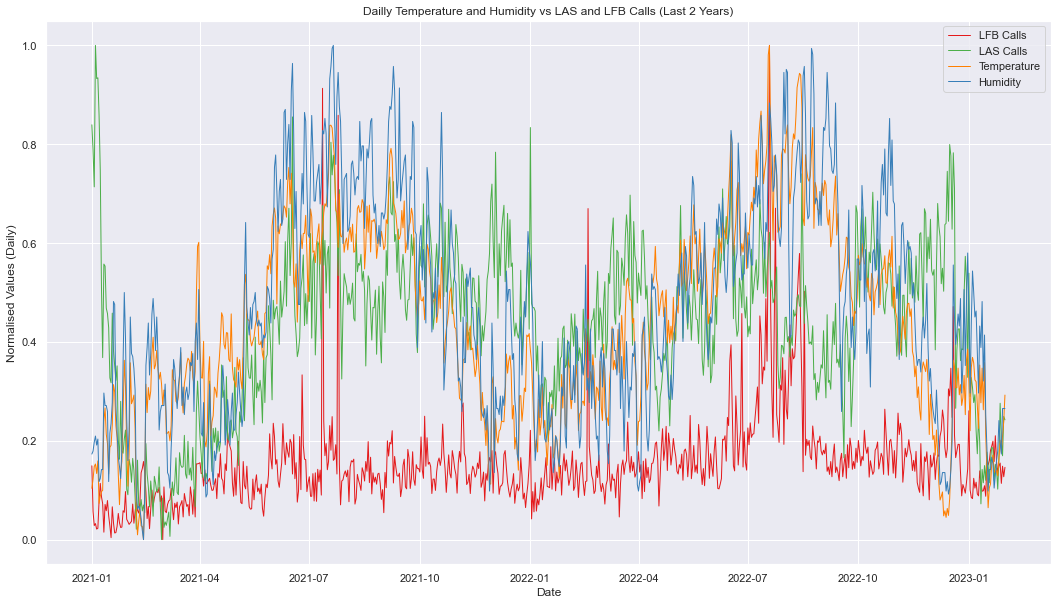

In [17]:
# Now re-plot your data
plt.figure(figsize=(18,10))
plt.plot(np.array(daily['DATE']), np.array(daily['NORM_LFB']), label='LFB Calls', color=colors['red'], linewidth=1)
plt.plot(np.array(daily['DATE']), np.array(daily['NORM_LAS']), label='LAS Calls', color=colors['green'], linewidth=1)
plt.plot(np.array(daily['DATE']), np.array(daily['NORM_MAX_TEMP']), label='Temperature', color=colors['orange'], linewidth=1)
plt.plot(np.array(daily['DATE']), np.array(daily['NORM_HUMIDITY']), label='Humidity', color=colors['blue'], linewidth=1)
plt.legend(loc='best')
plt.title('Dailly Temperature and Humidity vs LAS and LFB Calls (Last 2 Years)')
plt.xlabel('Date')
plt.ylabel('Normalised Values (Daily)')
plt.show()

**Daily LFB vs LAS**

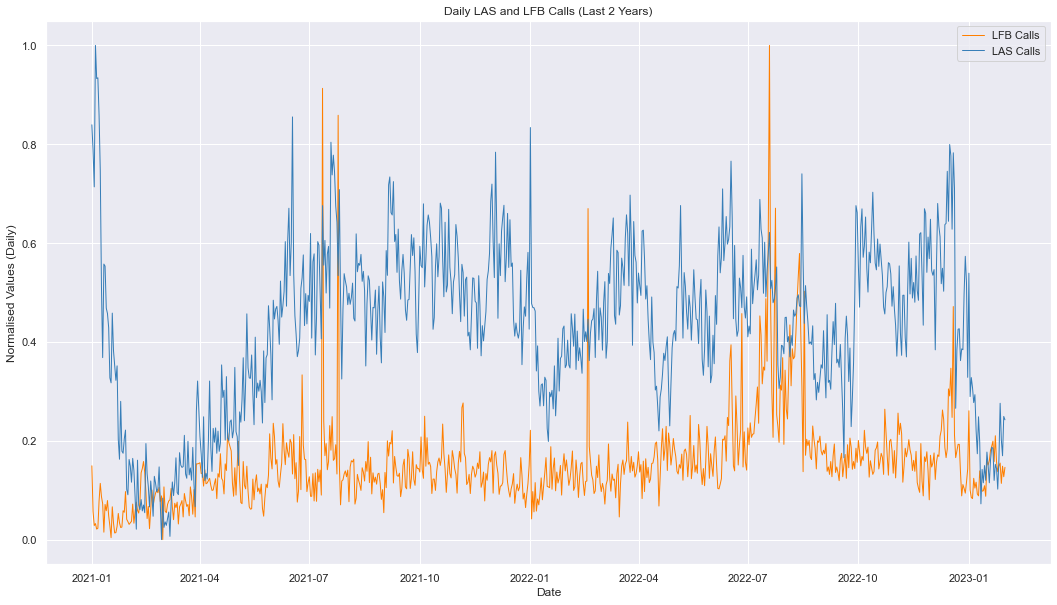

In [18]:
# Now re-plot your data
plt.figure(figsize=(18,10))
plt.plot(np.array(daily['DATE']), np.array(daily['NORM_LFB']), label='LFB Calls', color=colors['orange'], linewidth=1)
plt.plot(np.array(daily['DATE']), np.array(daily['NORM_LAS']), label='LAS Calls', color=colors['blue'], linewidth=1)
plt.legend(loc='best')
plt.title('Daily LAS and LFB Calls (Last 2 Years)')
plt.xlabel('Date')
plt.ylabel('Normalised Values (Daily)')
plt.show()

**Daily LAS vs Temperature and Humidity**

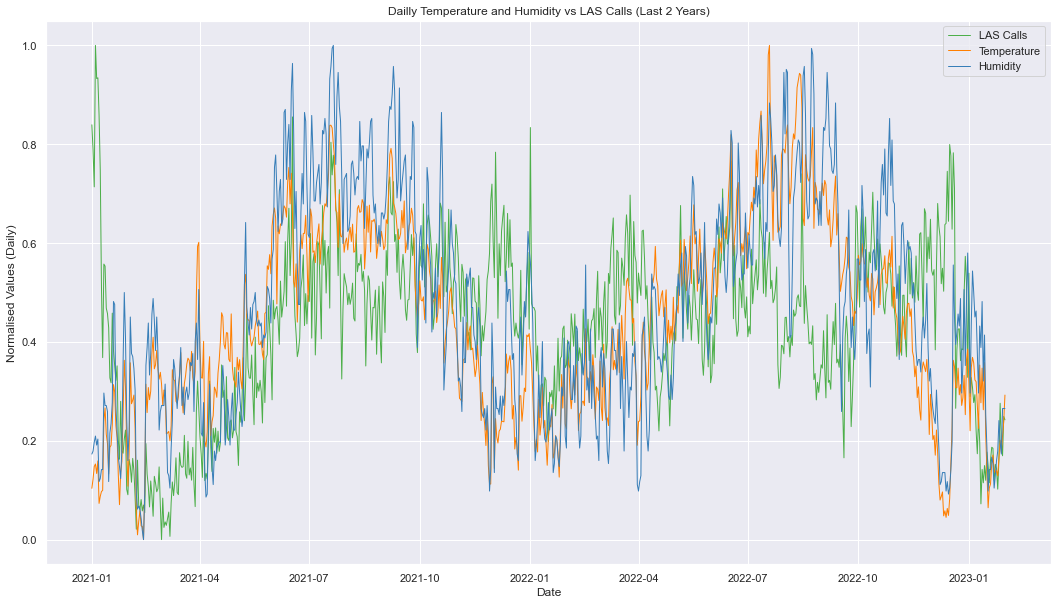

In [19]:
# Now re-plot your data
plt.figure(figsize=(18,10))
plt.plot(np.array(daily['DATE']), np.array(daily['NORM_LAS']), label='LAS Calls', color=colors['green'], linewidth=1)
plt.plot(np.array(daily['DATE']), np.array(daily['NORM_MAX_TEMP']), label='Temperature', color=colors['orange'], linewidth=1)
plt.plot(np.array(daily['DATE']), np.array(daily['NORM_HUMIDITY']), label='Humidity', color=colors['blue'], linewidth=1)
plt.legend(loc='best')
plt.title('Dailly Temperature and Humidity vs LAS Calls (Last 2 Years)')
plt.xlabel('Date')
plt.ylabel('Normalised Values (Daily)')
plt.show()

**Daily LFB vs Temperature and Humidity**

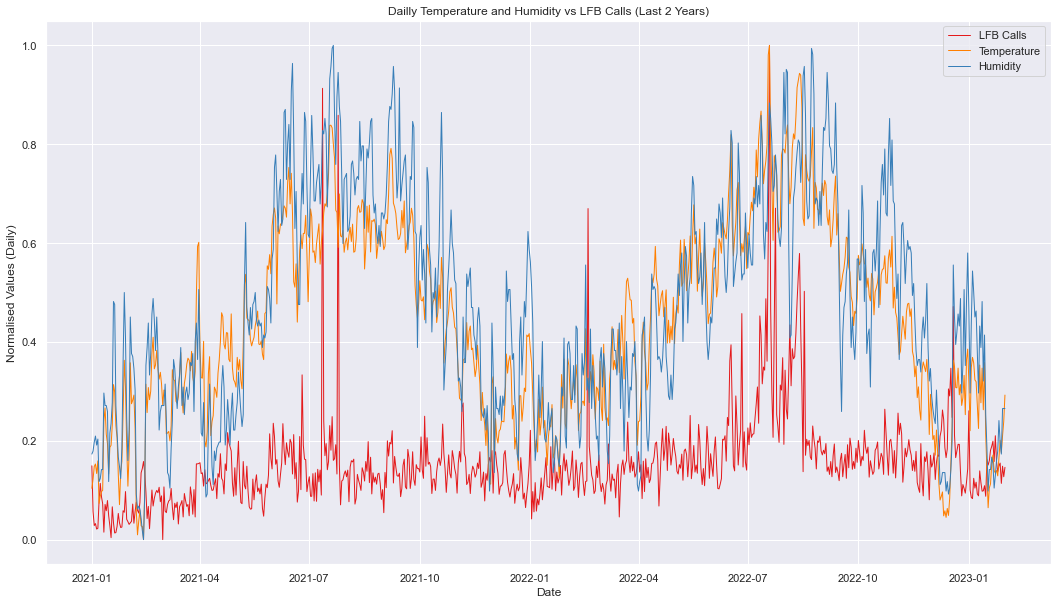

In [20]:
# Now re-plot your data
plt.figure(figsize=(18,10))
plt.plot(np.array(daily['DATE']), np.array(daily['NORM_LFB']), label='LFB Calls', color=colors['red'], linewidth=1)
plt.plot(np.array(daily['DATE']), np.array(daily['NORM_MAX_TEMP']), label='Temperature', color=colors['orange'], linewidth=1)
plt.plot(np.array(daily['DATE']), np.array(daily['NORM_HUMIDITY']), label='Humidity', color=colors['blue'], linewidth=1)
plt.legend(loc='best')
plt.title('Dailly Temperature and Humidity vs LFB Calls (Last 2 Years)')
plt.xlabel('Date')
plt.ylabel('Normalised Values (Daily)')
plt.show()

### WEEKLY

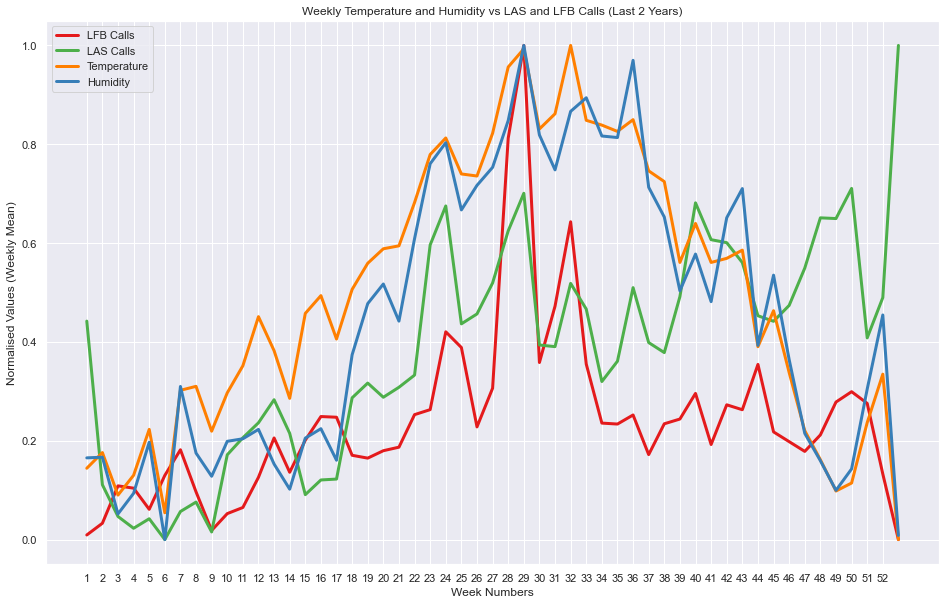

In [21]:
# Now re-plot your data
plt.figure(figsize=(16,10))
plt.plot(np.array(np.array(weekly['WEEK'])), np.array(np.array(weekly['NORM_LFB'])), label='LFB Calls', color=colors['red'], linewidth=3)
plt.plot(np.array(np.array(weekly['WEEK'])), np.array(np.array(weekly['NORM_LAS'])), label='LAS Calls', color=colors['green'], linewidth=3)
plt.plot(np.array(np.array(np.array(np.array(np.array(weekly['WEEK']))))), np.array(np.array(weekly['NORM_MAX_TEMP'])), label='Temperature', color=colors['orange'], linewidth=3)
plt.plot(np.array(np.array(weekly['WEEK'])), np.array(np.array(weekly['NORM_HUMIDITY'])), label='Humidity', color=colors['blue'], linewidth=3)
plt.legend(loc='best')
plt.title('Weekly Temperature and Humidity vs LAS and LFB Calls (Last 2 Years)')
plt.xlabel('Week Numbers')
plt.ylabel('Normalised Values (Weekly Mean)')
plt.xticks(np.arange(1, 53, 1)) # melted_df['value'].max()
plt.show()

**Weekly LAS vs LFB Calls**

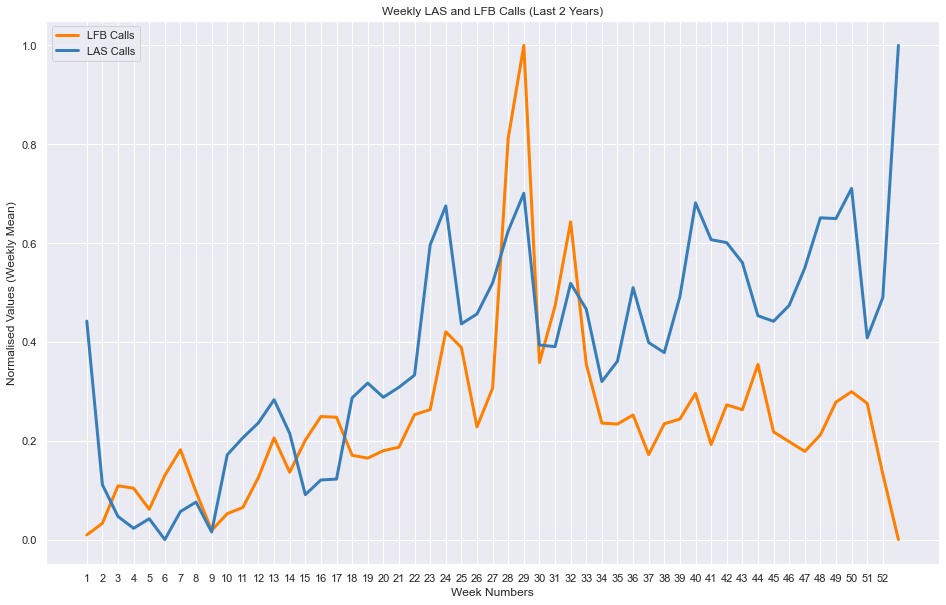

In [22]:
# Now re-plot your data
plt.figure(figsize=(16,10))
plt.plot(np.array(np.array(weekly['WEEK'])), np.array(np.array(weekly['NORM_LFB'])), label='LFB Calls', color=colors['orange'], linewidth=3)
plt.plot(np.array(np.array(weekly['WEEK'])), np.array(np.array(weekly['NORM_LAS'])), label='LAS Calls', color=colors['blue'], linewidth=3)
plt.legend(loc='best')
plt.title('Weekly LAS and LFB Calls (Last 2 Years)')
plt.xlabel('Week Numbers')
plt.ylabel('Normalised Values (Weekly Mean)')
plt.xticks(np.arange(1, 53, 1)) # melted_df['value'].max()
plt.show()

**Weekly LAS vs Temperature and Humidity Calls**

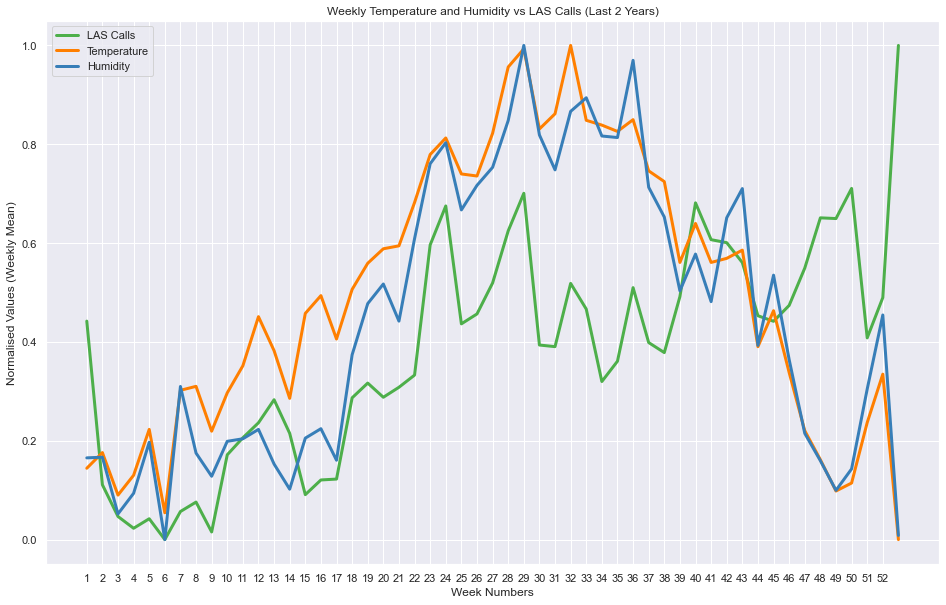

In [23]:
# Now re-plot your data
plt.figure(figsize=(16,10))
plt.plot(np.array(weekly['WEEK']), np.array(weekly['NORM_LAS']), label='LAS Calls', color=colors['green'], linewidth=3)
plt.plot(np.array(weekly['WEEK']), np.array(weekly['NORM_MAX_TEMP']), label='Temperature', color=colors['orange'], linewidth=3)
plt.plot(np.array(weekly['WEEK']), np.array(weekly['NORM_HUMIDITY']), label='Humidity', color=colors['blue'], linewidth=3)
plt.legend(loc='best')
plt.title('Weekly Temperature and Humidity vs LAS Calls (Last 2 Years)')
plt.xlabel('Week Numbers')
plt.ylabel('Normalised Values (Weekly Mean)')
plt.xticks(np.arange(1, 53, 1)) # melted_df['value'].max()
plt.show()

**Weekly LFB vs Temperature and Humidity Calls**

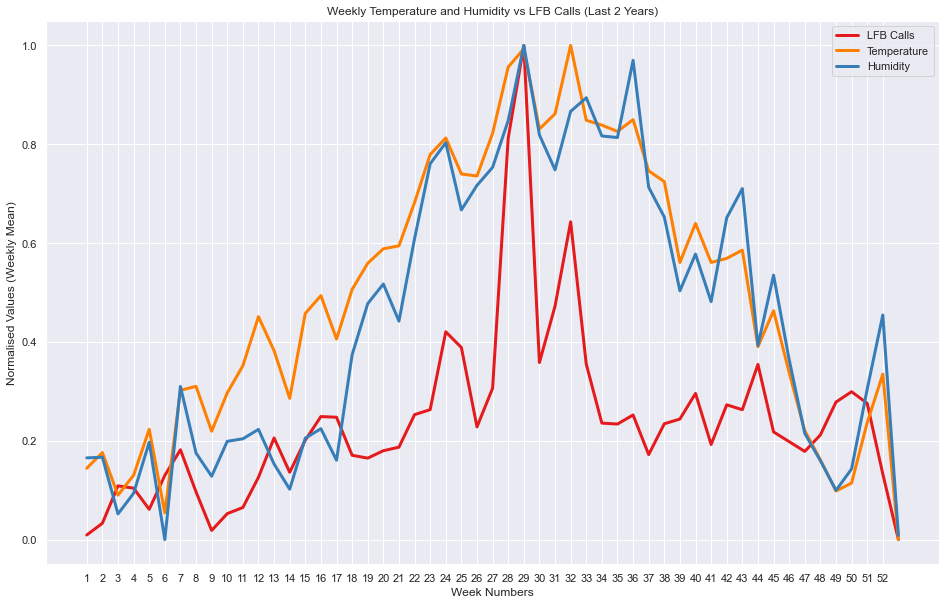

In [24]:
# Now re-plot your data
plt.figure(figsize=(16,10))
plt.plot(np.array(weekly['WEEK']), np.array(weekly['NORM_LFB']), label='LFB Calls', color=colors['red'], linewidth=3)
plt.plot(np.array(weekly['WEEK']), np.array(weekly['NORM_MAX_TEMP']), label='Temperature', color=colors['orange'], linewidth=3)
plt.plot(np.array(weekly['WEEK']), np.array(weekly['NORM_HUMIDITY']), label='Humidity', color=colors['blue'], linewidth=3)
plt.legend(loc='best')
plt.title('Weekly Temperature and Humidity vs LFB Calls (Last 2 Years)')
plt.xlabel('Week Numbers')
plt.ylabel('Normalised Values (Weekly Mean)')
plt.xticks(np.arange(1, 53, 1)) # melted_df['value'].max()
plt.show()

### MONTHLY 

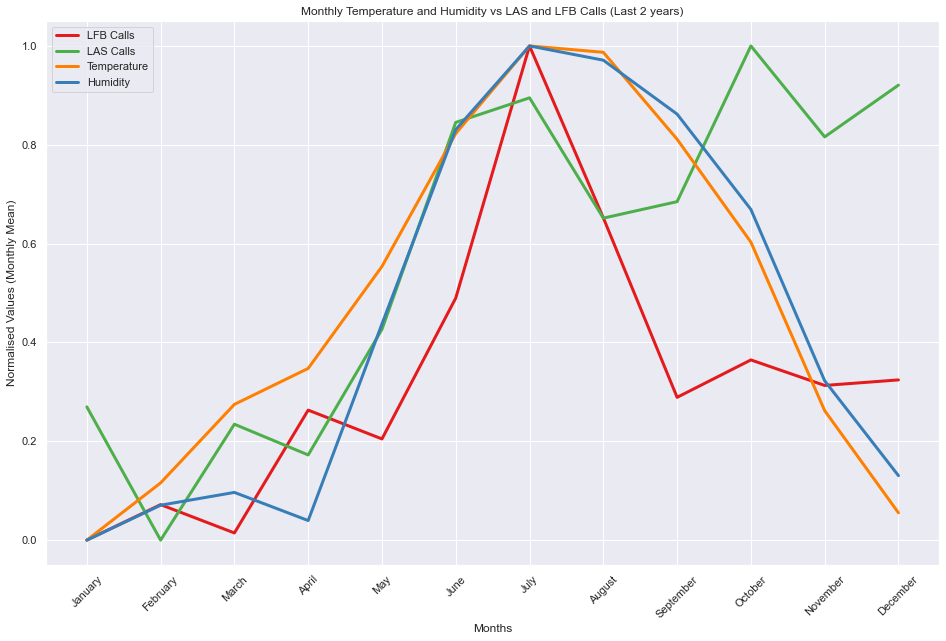

In [25]:
# Ensure you have a list of all the months
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(16,10))
plt.plot(np.array(monthly['MONTH']), np.array(monthly['NORM_LFB']), label='LFB Calls', color=colors['red'], linewidth=3)
plt.plot(np.array(monthly['MONTH']), np.array(monthly['NORM_LAS']), label='LAS Calls', color=colors['green'], linewidth=3)
plt.plot(np.array(monthly['MONTH']), np.array(monthly['NORM_MAX_TEMP']), label='Temperature', color=colors['orange'], linewidth=3)
plt.plot(np.array(monthly['MONTH']), np.array(monthly['NORM_HUMIDITY']), label='Humidity', color=colors['blue'], linewidth=3)
plt.legend(loc='best')
plt.title('Monthly Temperature and Humidity vs LAS and LFB Calls (Last 2 years)')
plt.xlabel('Months')
plt.ylabel('Normalised Values (Monthly Mean)')
plt.xticks(range(1, len(months)+1), months, rotation=45)
plt.show()

**Monthly LAS vs LFB Calls**

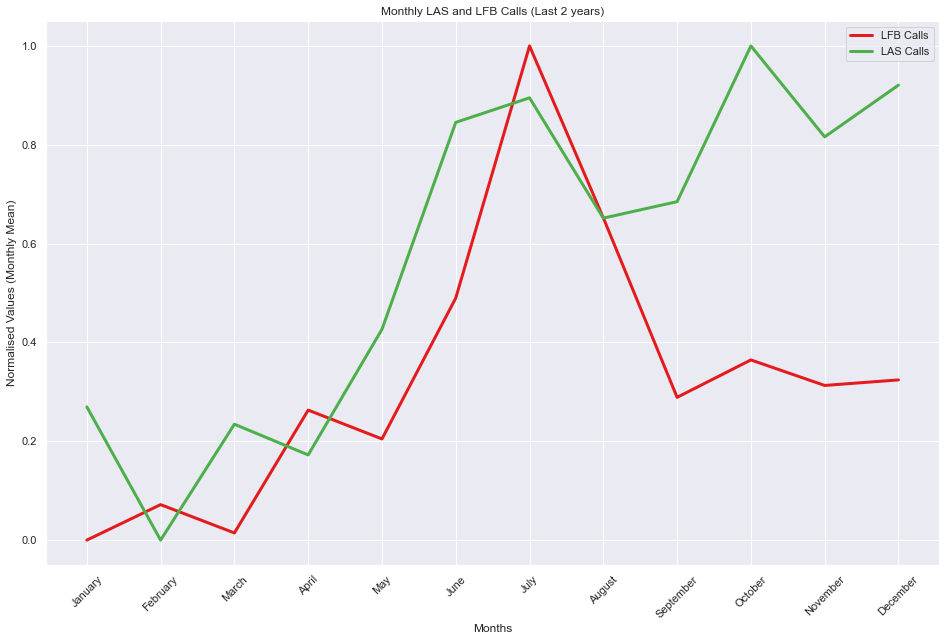

In [26]:
# Ensure you have a list of all the months
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(16,10))
plt.plot(np.array(monthly['MONTH']), np.array(monthly['NORM_LFB']), label='LFB Calls', color=colors['red'], linewidth=3)
plt.plot(np.array(monthly['MONTH']), np.array(monthly['NORM_LAS']), label='LAS Calls', color=colors['green'], linewidth=3)
plt.legend(loc='best')
plt.title('Monthly LAS and LFB Calls (Last 2 years)')
plt.xlabel('Months')
plt.ylabel('Normalised Values (Monthly Mean)')
plt.xticks(range(1, len(months)+1), months, rotation=45)
plt.show()

**Montly LAS vs Temperature and Humidity**

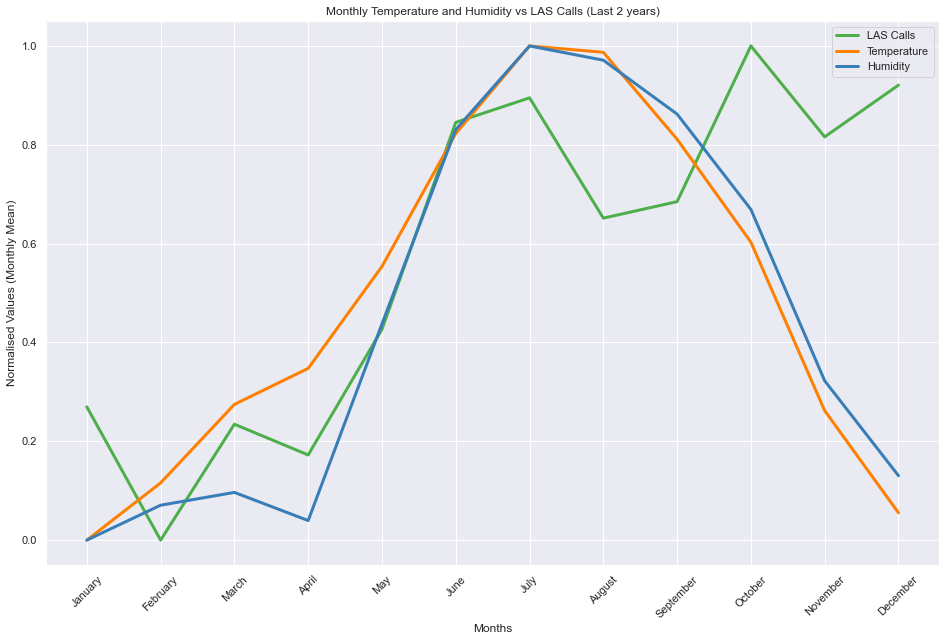

In [27]:
# Ensure you have a list of all the months
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(16,10))
plt.plot(np.array(monthly['MONTH']), np.array(monthly['NORM_LAS']), label='LAS Calls', color=colors['green'], linewidth=3)
plt.plot(np.array(monthly['MONTH']), np.array(monthly['NORM_MAX_TEMP']), label='Temperature', color=colors['orange'], linewidth=3)
plt.plot(np.array(monthly['MONTH']), np.array(monthly['NORM_HUMIDITY']), label='Humidity', color=colors['blue'], linewidth=3)
plt.legend(loc='best')
plt.title('Monthly Temperature and Humidity vs LAS Calls (Last 2 years)')
plt.xlabel('Months')
plt.ylabel('Normalised Values (Monthly Mean)')
plt.xticks(range(1, len(months)+1), months, rotation=45)
plt.show()

**Montly LFB vs Temperature and Humidity**

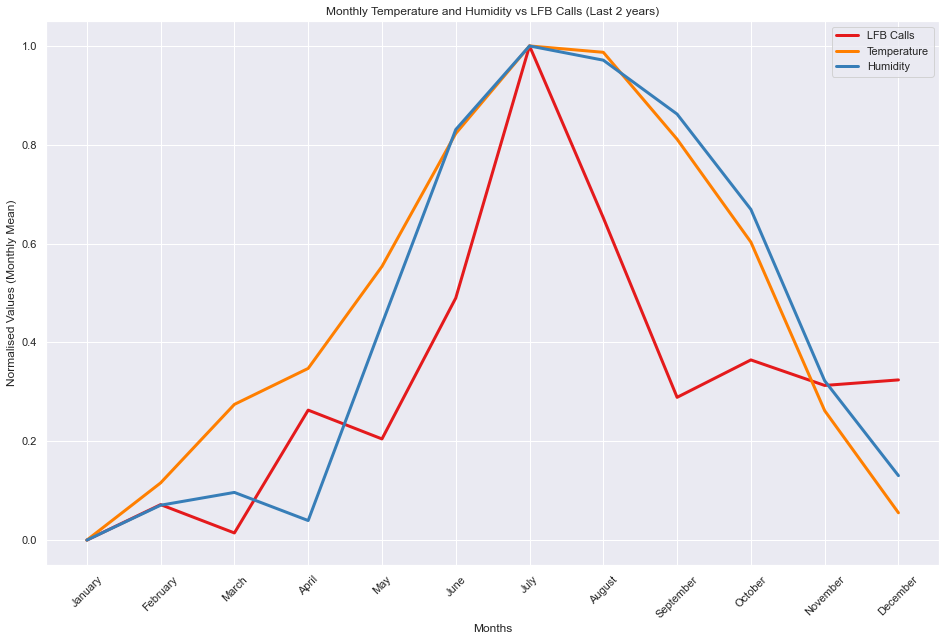

In [28]:
# Ensure you have a list of all the months
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(16,10))
plt.plot(np.array(monthly['MONTH']), np.array(monthly['NORM_LFB']), label='LFB Calls', color=colors['red'], linewidth=3)
plt.plot(np.array(monthly['MONTH']), np.array(monthly['NORM_MAX_TEMP']), label='Temperature', color=colors['orange'], linewidth=3)
plt.plot(np.array(monthly['MONTH']), np.array(monthly['NORM_HUMIDITY']), label='Humidity', color=colors['blue'], linewidth=3)
plt.legend(loc='best')
plt.title('Monthly Temperature and Humidity vs LFB Calls (Last 2 years)')
plt.xlabel('Months')
plt.ylabel('Normalised Values (Monthly Mean)')
plt.xticks(range(1, len(months)+1), months, rotation=45)
plt.show()